# Gesture Recognition


#### 1. Importing required libraries
Note: Using skimage and tensorflow 2.3.0.

In [1]:
import numpy as np
import os
from skimage import io
from skimage.transform import resize
import datetime
import os
import pandas as pd

In [2]:
#importing tensorflow and keras library for model building 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications import InceptionV3



C:\Users\others\.conda\envs\gesture\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\others\.conda\envs\gesture\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\others\.conda\envs\gesture\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\others\.conda\envs\gesture\lib\site-packages\tensorflow\python\f

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)

import tensorflow as tf
tf.set_random_seed(30)

Reading the csv using pandas so that we can choose part of data programatically

In [5]:
 
header_list = ["Folder_name", "Class_name", "Class_id"]
#This flag if set true lets select partial dataset
ablation_flag=True 
#num of classes * ablation_data_per_class for training dataset
#num of classes * ablation_data_per_class/2 for validation dataset 
ablation_data_per_class=20
if ablation_flag:
    train_doc_df=pd.read_csv('Project_data/train.csv',sep=';',names=header_list)
    #Only selecting per class ablation_data_per_class dataset
    temp_df = train_doc_df.groupby('Class_id').head(ablation_data_per_class)
    #shuffling the dataset
    train_doc = temp_df.iloc[np.random.permutation(len(temp_df))]
    
    val_doc_df=pd.read_csv('Project_data/val.csv',sep=';',names=header_list)
    #Choosing half amount of dataset for validation  
    temp_val_df = val_doc_df.groupby('Class_id').head(ablation_data_per_class//2)
    val_doc = temp_val_df.iloc[np.random.permutation(len(temp_val_df))]
else:
    #Choosing all the dataset
    train_doc_df = pd.read_csv('Project_data/train.csv',sep=';',names=header_list)
    #shuffling the dataset
    train_doc = train_doc_df.iloc[np.random.permutation(len(train_doc_df))]
    val_doc_df = pd.read_csv('Project_data/val.csv',sep=';',names=header_list)
    val_doc = val_doc_df.iloc[np.random.permutation(len(val_doc_df))]
    



Checking the final data loaded in dataframe

In [6]:
val_doc

,Folder_name,Class_name,Class_id
41,WIN_20180925_17_35_29_Pro_Thumbs_Down_new,Thumbs_Down_new,3
19,WIN_20180926_17_12_27_Pro_Right_Swipe_new,Right_Swipe_new,1
56,WIN_20180925_17_58_08_Pro_Thumbs_Up_new,Thumbs_Up_new,4
47,WIN_20180926_17_09_45_Pro_Thumbs_Down_new,Thumbs_Down_new,3
58,WIN_20180926_16_43_34_Pro_Thumbs_Up_new,Thumbs_Up_new,4
53,WIN_20180925_17_38_43_Pro_Thumbs_Up_new,Thumbs_Up_new,4
30,WIN_20180925_17_52_42_Pro_Stop_new,Stop_new,2
14,WIN_20180925_17_43_46_Pro_Right_Swipe_new,Right_Swipe_new,1
26,WIN_20180925_17_30_40_Pro_Stop_new,Stop_new,2
48,WIN_20180926_17_13_25_Pro_Thumbs_Down_new,Thumbs_Down_new,3


In [7]:
len(train_doc)

100

#### 2. Generator


In [8]:
# Selecting half of the data    
img_idx = [s for s in range(0, 30, 2)]
# Total number of images from sequence
x = len(img_idx) 
# size of image 120 X 120
y = z = 120 


In [9]:

def generator(source_path, folder_list, batch_size):
    global x, y, z
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t_df = folder_list.iloc[np.random.permutation(len(folder_list))]
        # calculate the number of batches
        num_batches = len(t_df)//batch_size
        # we iterate over the number of batches
        for batch in range(num_batches):
            # x is the number of images you use for each video, (
            # y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,x,y,z,3))
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))
            # iterate over the batch_size
            for folder in range(batch_size): 
                # read all the images in the folder
                imgs = os.listdir(source_path+'/'+ t_df['Folder_name'].iloc[folder+(batch*batch_size)])
                #  Iterate over the frames/images of a folder to read them in
                for idx,item in enumerate(img_idx): 
                    image = io.imread(source_path+'/'+ t_df['Folder_name'].iloc[folder + (batch*batch_size)]+'/'+imgs[item]).astype(np.float32)
                    # Resizing the images. Didn't crop images as couldn't find common waste region             
                    img_resiz = resize(image,(y,z))
                    # Using normalization by dividing by 255(max pixel value possible). 
                    # In this view we have access to only 1 image not entire dataset to 
                    # normalizing within the image using minmax or standard scaling may be misleading.
                    batch_data[folder,idx,:,:,0] = (img_resiz[:,:,0])/255.0
                    batch_data[folder,idx,:,:,1] = (img_resiz[:,:,1])/255.0
                    batch_data[folder,idx,:,:,2] = (img_resiz[:,:,2])/255.0
                                
                batch_labels[folder,int(t_df['Class_id'].iloc[folder + (batch*batch_size)])] = 1
            yield batch_data, batch_labels
        #Check for Remaining data    
        remaining_sequ = len(t_df) - (num_batches*batch_size)
        if remaining_sequ > 0:
            batch_data = np.zeros((remaining_sequ,x,y,z,3)) 
            batch_labels = np.zeros((remaining_sequ,5))
            #Iterate through remaining data
            for i,folder in enumerate(range((num_batches*batch_size),len(t_df))):
                imgs = os.listdir(source_path+'/'+ t_df['Folder_name'].iloc[folder])
                for idx,item in enumerate(img_idx):
                    image = io.imread(source_path+'/'+ t_df['Folder_name'].iloc[folder]+'/'+imgs[item]).astype(np.float32)
                    img_resiz = resize(image,(y,z))
                    batch_data[i,idx,:,:,0] = (img_resiz[:,:,0])/255.0
                    batch_data[i,idx,:,:,1] = (img_resiz[:,:,1])/255.0
                    batch_data[i,idx,:,:,2] = (img_resiz[:,:,2])/255.0
                batch_labels[i, int(t_df['Class_id'].iloc[folder])] = 1
            yield batch_data,batch_labels
                                         


Dummy code for testing the Generator

In [10]:
train_path = 'Project_data/train'
batch_test_size = 5

In [11]:
train_generator = generator(train_path, train_doc, batch_test_size)

In [12]:
data,labels = next(train_generator)

Source path =  Project_data/train ; batch size = 5


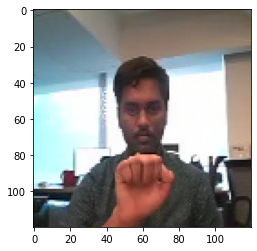

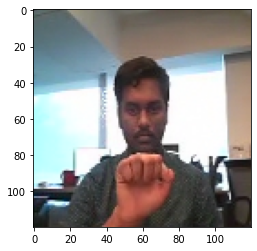

[0. 0. 1. 0. 0.]


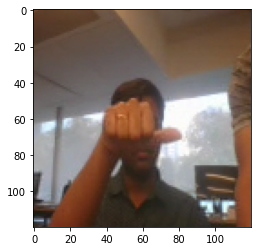

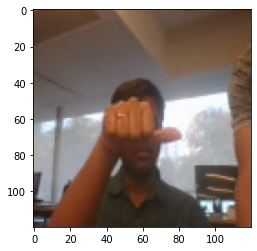

[0. 0. 0. 1. 0.]


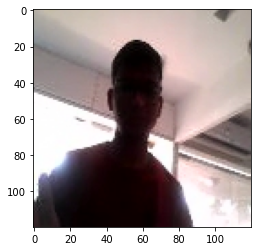

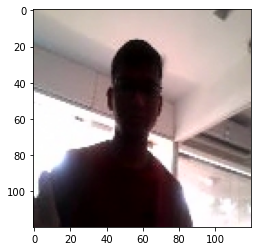

[1. 0. 0. 0. 0.]


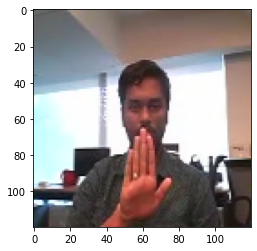

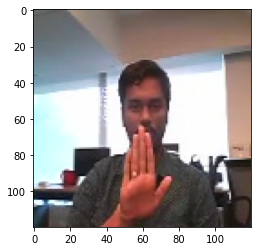

[0. 0. 1. 0. 0.]


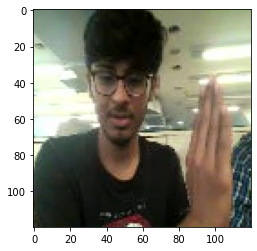

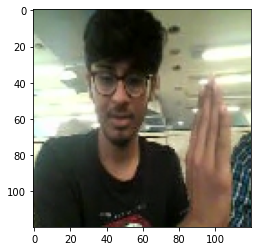

[0. 1. 0. 0. 0.]


In [13]:
#Display output from the generator
for i in range(batch_test_size):
    # Display first 2 images from the sequence
    for j in [0, 1]:
        img = data[i,j]
        plt.imshow(img)
        plt.show()
    lab = labels[i]
    print(lab)

#### 3. Setting Parameters
batch size, epochs, size of training and val dataset, etc

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
# This batch size is optimum, at 10 I am getting Kernel Crash
batch_size = 7 
print ('# epochs =', num_epochs)
print ('# batch size =', batch_size)

# training sequences = 100
# validation sequences = 50
# epochs = 15
# batch size = 7


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Let us set the callbacks for saving checkpoints  and adjusting learning rate  

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Calculate Steps per Epoch which will be passed in fit_generator

Defining a function to plot the trend of loss and accuracy

In [15]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

#### 3. Model Building


## Model: CNN + RNN Architecture

Using Inception v3 pretrained with imgenet weights

In [16]:
cnn_model = InceptionV3(include_top=False, weights='imagenet')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Model 1: InceptionV3 Pretrained CNN model + GRU

In [19]:
model_3 = Sequential()
model_3.add(TimeDistributed(cnn_model,input_shape=(x,y,z,3)))
model_3.add(TimeDistributed(BatchNormalization()))
model_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_3.add(TimeDistributed(Flatten()))
#Keeping default activation=tanh and recurrent_activation = sigmoid 
model_3.add(GRU(1024))
model_3.add(Dropout(0.5))

model_3.add(Dense(1024,activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(5, activation='softmax'))

In [20]:
optimiser = optimizers.Adam(lr=0.0001)
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 2, 2, 2048)    21802784  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 2, 2, 2048)    8192      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 1, 1, 2048)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 2048)          0         
_________________________________________________________________
gru (GRU)                    (None, 1024)              9440256   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1

In [21]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [22]:
history_3 = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 7
Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
14/15 [===========================>..] - ETA: 59s - loss: 1.9912 - categorical_accuracy: 0.1939 Source path =  Project_data/val ; batch size = 7

Epoch 00001: saving model to model_init_2020-12-1920_19_54.063962/model-00001-2.00218-0.19000-1.95065-0.16000.h5
15/15 [==============================] - 1062s 71s/step - loss: 2.0261 - categorical_accuracy: 0.1900 - val_loss: 1.9507 - val_categorical_accuracy: 0.1600
Epoch 2/15
14/15 [===========================>..] - ETA: 1:23 - loss: 1.5228 - categorical_accuracy: 0.3571
Epoch 00002: saving model to model_init_2020-12-1920_19_54.063962/model-00002-1.53916-0.35000-1.78006-0.26000.h5
15/15 [==============================] - 1316s 88s/step - loss: 1.5750 - categorical_accuracy: 0.3500 - val_loss: 1.7801 - val_categorical_accuracy: 0.2600
Epoch 3/15
14/15 [===========================>..] - 

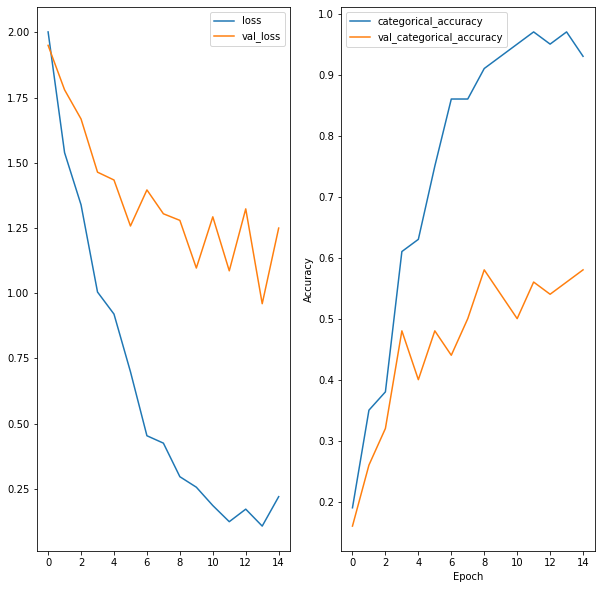

In [23]:
plot(history_3)

### Model 2: InceptionV3 Pretrained CNN model + GRU

In [15]:
model_2 = Sequential()
model_2.add(TimeDistributed(cnn_model,input_shape=(x,y,z,3)))
model_2.add(TimeDistributed(BatchNormalization()))
model_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_2.add(TimeDistributed(Flatten()))
model_2.add(GRU(64))
model_2.add(Dropout(0.5))

model_2.add(Dense(64,activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(8,activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(5, activation='softmax'))

In [16]:
optimiser = optimizers.Adam(lr=0.0001)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 2, 2, 2048)    21802784  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 2, 2, 2048)    8192      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 1, 1, 2048)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 2048)          0         
_________________________________________________________________
gru (GRU)                    (None, 64)                405696    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

##### To train from checkpoint convert this to CODE cell
checkpoint_path ='model_init_2020-12-1711_09_33.349418/model-00010-1.49585-0.35000-1.27650-0.56000.h5'
model_2.load_weights(checkpoint_path)

In [18]:
history_2 = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 7
Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
14/15 [===========================>..] - ETA: 36s - loss: 2.2169 - categorical_accuracy: 0.1939 Source path =  Project_data/val ; batch size = 7

Epoch 00001: saving model to model_init_2020-12-2008_53_18.995385/model-00001-2.21538-0.19000-1.73534-0.18000.h5
15/15 [==============================] - 581s 39s/step - loss: 2.2120 - categorical_accuracy: 0.1900 - val_loss: 1.7353 - val_categorical_accuracy: 0.1800
Epoch 2/15
14/15 [===========================>..] - ETA: 33s - loss: 1.8290 - categorical_accuracy: 0.2245 
Epoch 00002: saving model to model_init_2020-12-2008_53_18.995385/model-00002-1.81629-0.23000-1.79319-0.18000.h5
15/15 [==============================] - 518s 35s/step - loss: 1.7885 - categorical_accuracy: 0.2300 - val_loss: 1.7932 - val_categorical_accuracy: 0.1800
Epoch 3/15
14/15 [===========================>..] - ET

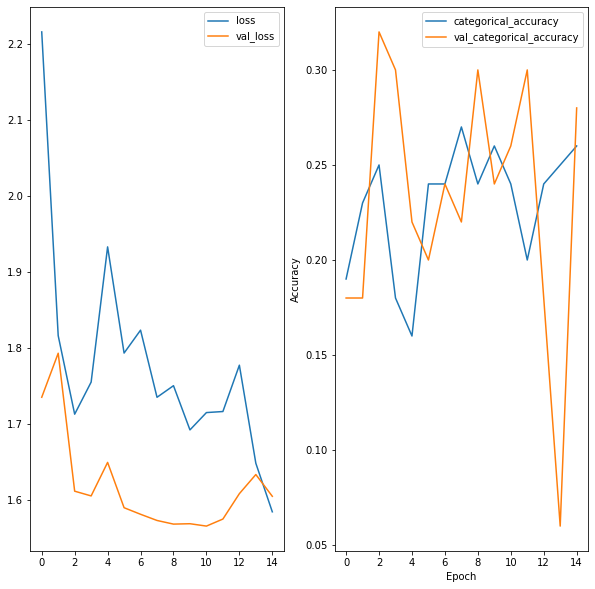

In [19]:
plot(history_2)

### Model 3: InceptionV3 Pretrained CNN model + GRU

In [17]:
model_1 = Sequential()
model_1.add(TimeDistributed(cnn_model,input_shape=(x,y,z,3)))
model_1.add(TimeDistributed(BatchNormalization()))
model_1.add(TimeDistributed(MaxPooling2D((2, 2))))
model_1.add(TimeDistributed(Flatten()))
model_1.add(GRU(256))
model_1.add(Dropout(0.5))

model_1.add(Dense(256,activation='relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(128,activation='relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(5, activation='softmax'))

In [18]:
optimiser = optimizers.Adam(lr=0.0001) 
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 2, 2, 2048)    21802784  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 2, 2, 2048)    8192      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 1, 1, 2048)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 2048)          0         
_________________________________________________________________
gru (GRU)                    (None, 256)               1770240   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

##### To train from checkpoint convert this to CODE cell
checkpoint_path ='model_init_2020-12-1423_10_37.895040/model-00010-0.63495-0.77979-0.49056-0.83000.h5'
model_1.load_weights(checkpoint_path)

In [20]:
history_1 = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 7
Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
14/15 [===========================>..] - ETA: 38s - loss: 1.9899 - categorical_accuracy: 0.2245 Source path =  Project_data/val ; batch size = 7

Epoch 00001: saving model to model_init_2020-12-2011_48_20.368387/model-00001-2.00296-0.22000-1.64994-0.18000.h5
15/15 [==============================] - 612s 41s/step - loss: 2.0315 - categorical_accuracy: 0.2200 - val_loss: 1.6499 - val_categorical_accuracy: 0.1800
Epoch 2/15
14/15 [===========================>..] - ETA: 34s - loss: 2.0343 - categorical_accuracy: 0.2551 
Epoch 00002: saving model to model_init_2020-12-2011_48_20.368387/model-00002-2.05163-0.25000-1.60969-0.22000.h5
15/15 [==============================] - 526s 35s/step - loss: 2.0895 - categorical_accuracy: 0.2500 - val_loss: 1.6097 - val_categorical_accuracy: 0.2200
Epoch 3/15
14/15 [===========================>..] - ET

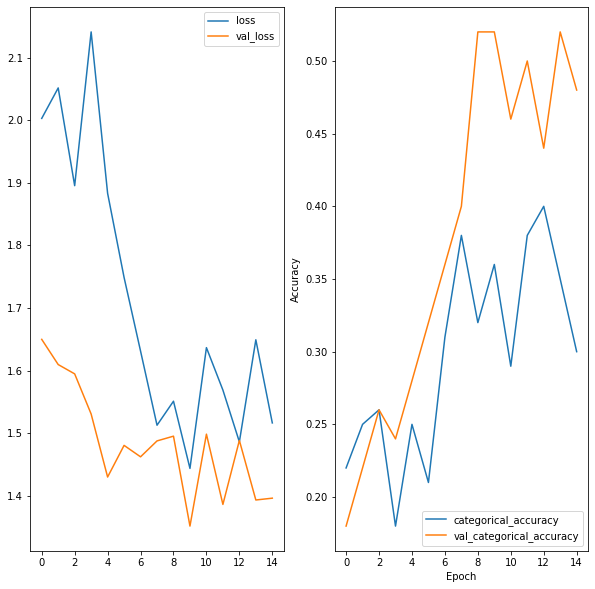

In [21]:
plot(history_1)

In [22]:
checkpoint_path ='model_init_2020-12-1520_20_05.913645_m1/model-00011-0.09640-0.97738-0.35520-0.95000.h5'
model_1.load_weights(checkpoint_path)

In [25]:
results_val = model_1.evaluate_generator(val_generator, steps=validation_steps, verbose=1)
print("validation loss, validation acc:", results_val)

8/8 [==============================] - 37s 5s/step - loss: 0.2093 - categorical_accuracy: 0.9800
validation loss, validation acc: [0.20930781663992093, 0.98]


In [30]:
val_data,val_labels = next(val_generator)

In [31]:
pred = model_1.predict_on_batch(val_data)

In [42]:
print(pred[2])

[1.0467749e-05 1.1810843e-05 1.7323809e-04 1.0467804e-04 9.9969983e-01]


In [43]:
print(np.argmax(pred[2]))

4


In [44]:
class_label = ['swipe_left', 'swipe_right', 'stop', 'thums_down', 'thumbs_up']

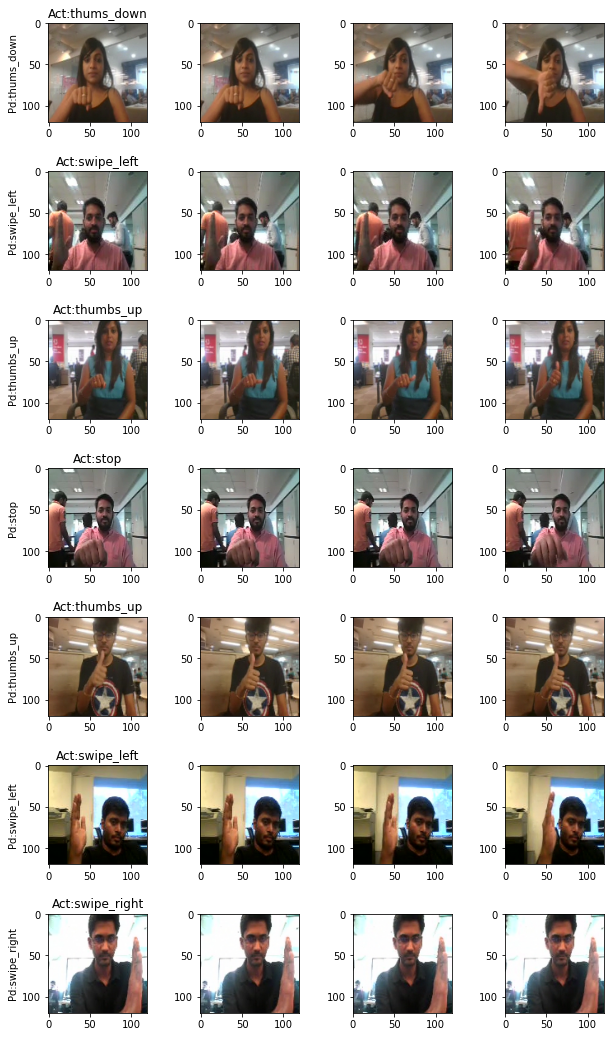

In [52]:
fig, axs = plt.subplots(batch_size, 4, figsize=(10, 10))
for i in range(batch_size):
    # Display first 2 images from the sequence
    for idx,j in enumerate([0, 1, 3, 6]):
        img = val_data[i,j]
        axs[i][idx].imshow(img)
    axs[i][0].set_title("Act:{}".format(class_label[np.argmax(val_labels[i])]))
    axs[i][0].set_ylabel("Pd:{}".format(class_label[np.argmax(pred[i])]))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=0.5, hspace=0.5)
       
plt.show()